## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'standardTesting-full' 
TRANSFORM = 'wavelet-vertical'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_vertical_wavelet_full_standardTesting.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

'd:\\new research\\hierarchical-bayesian-model-validation\\results\\case-studies\\standardTesting\\full\\wavelet\\vertical\\gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9,
 3: 36,
 4: 144,
 5: 576,
 6: 2304,
 7: 9216,
 8: 36864,
 9: 147456,
 10: 589824}

Running 12760 CDFs


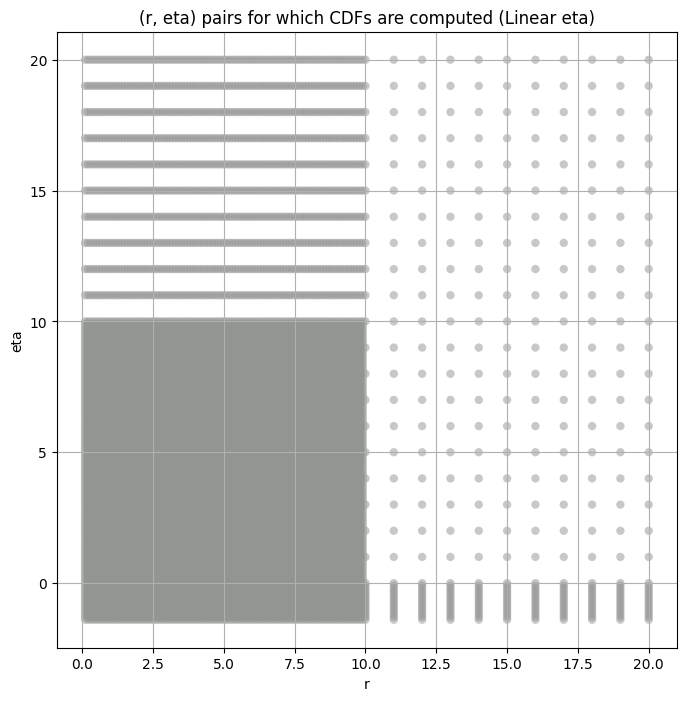

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                   
2      12133.633000  1262.640100  24858.705000  -0.200231   -1.861119   
3       4988.553000  2210.085700   9074.969000   0.829951   -1.383874   
4       1117.262500   710.023300   1577.433700   1.373115    0.269231   
5        296.334600   229.935680    370.397920   2.907261    1.430172   
6         58.387070    50.698250     66.482250   4.324181    3.389756   
7         10.897633    10.028848     11.798168   7.070075    5.927161   
8          2.093454     1.924215      2.268933   8.196066    7.150843   
9          0.375532     0.342325      0.410297  10.374654    8.507622   
10         0.059142     0.053647      0.065072  12.091230    9.378087   

       kurt_upper  total_samples  
layer                             
2        2.882851            9.0  
3        2.973324           36.0  
4        2.707083          144.0  
5        4.404983          576.0  
6        5.462243         2304.0  
7        8.451274         9216.0  
8        9.390152        36864.0  
9       12.769254       147456.0  
10      15.769087       589824.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      12133.633000   12133.632812             NaN             NaN   
3       4988.553000    4988.553223             NaN             NaN   
4       1117.262500    1117.262451      180.566193       25.094305   
5        296.334600     296.334595      137.858719       83.411652   
6         58.387070      58.387070       41.731201       32.499660   
7         10.897633      10.897633        9.379966        8.417982   
8          2.093454       2.093454        1.985067        1.905213   
9          0.375532       0.375532        0.363635        0.355125   
10         0.059142       0.059142        0.056844        0.055335   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2                 NaN              NaN              NaN              NaN   
3                 NaN              NaN              NaN              NaN   
4                 NaN              NaN              NaN              NaN   
5           51.156162        31.517448        11.240232         3.183513   
6           26.132250        21.522749        15.104354        11.022488   
7            7.636009         6.993498         5.979763         5.228056   
8            1.836614         1.774066         1.661684         1.565422   
9            0.347910         0.341509         0.330155         0.320124   
10           0.054099         0.053016         0.051130         0.049515   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2                  NaN              NaN              NaN              NaN  
3                  NaN              NaN              NaN              NaN  
4                  NaN              NaN              NaN              NaN  
5             0.455785              NaN              NaN              NaN  
6             8.254154         6.274473         4.784652         2.039555  
7             4.637155         4.152267         3.741277         2.774511  
8             1.481194         1.405993         1.337479         1.168221  
9             0.311042         0.302681         0.294977         0.274907  
10            0.048072         0.046752         0.045526         0.042295

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.2936526629867171 12133.633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 nan nan
Number of samples: 9, Without approximation : 9.0


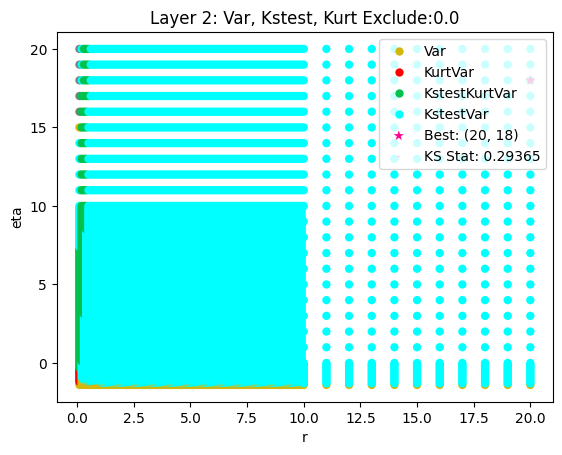

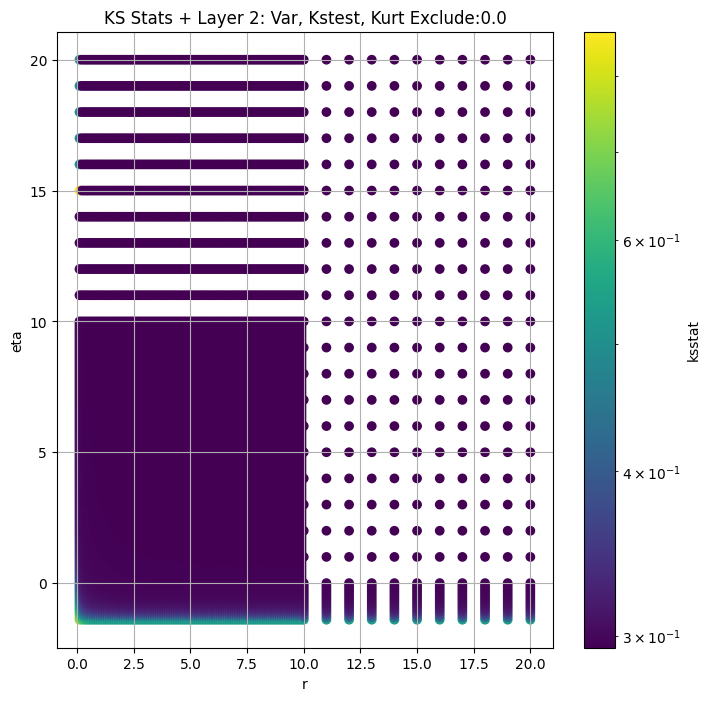

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.14443709421730433 4988.553


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 nan nan
Number of samples: 36, Without approximation : 36.0


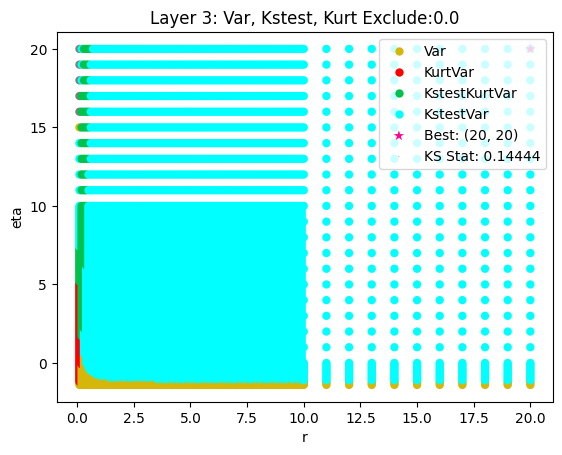

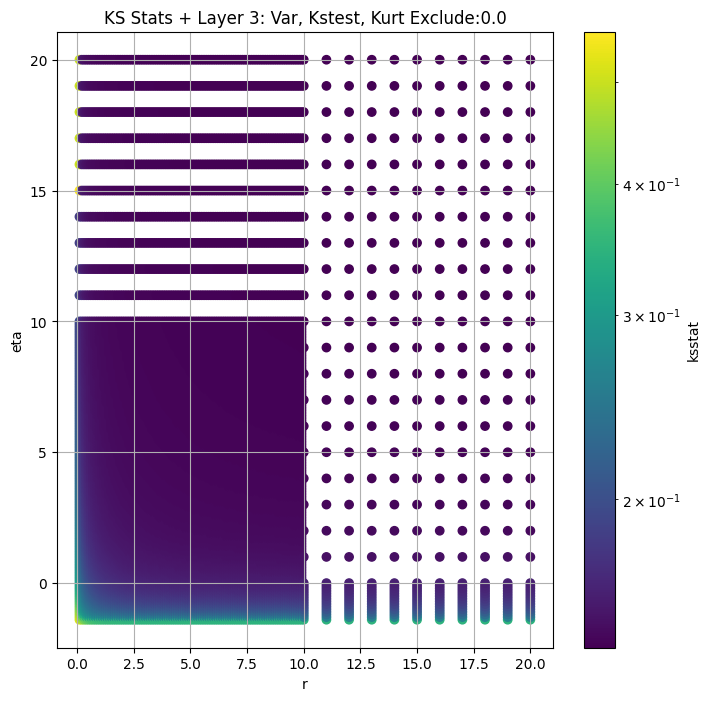

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03207298071419762 1117.2625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.1808060531595337 180.5662


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.31704252461293725 25.094305


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 nan nan
Number of samples: 144, Without approximation : 144.0


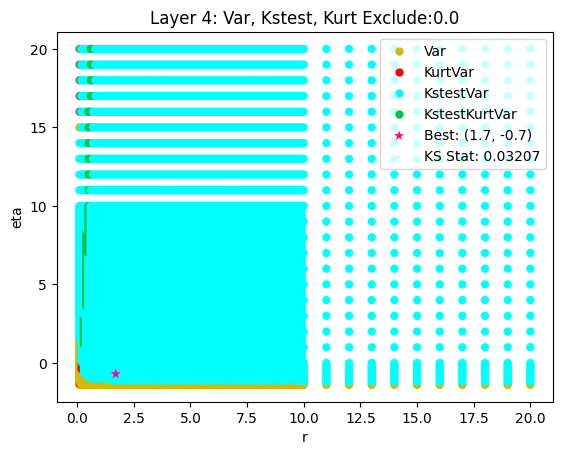

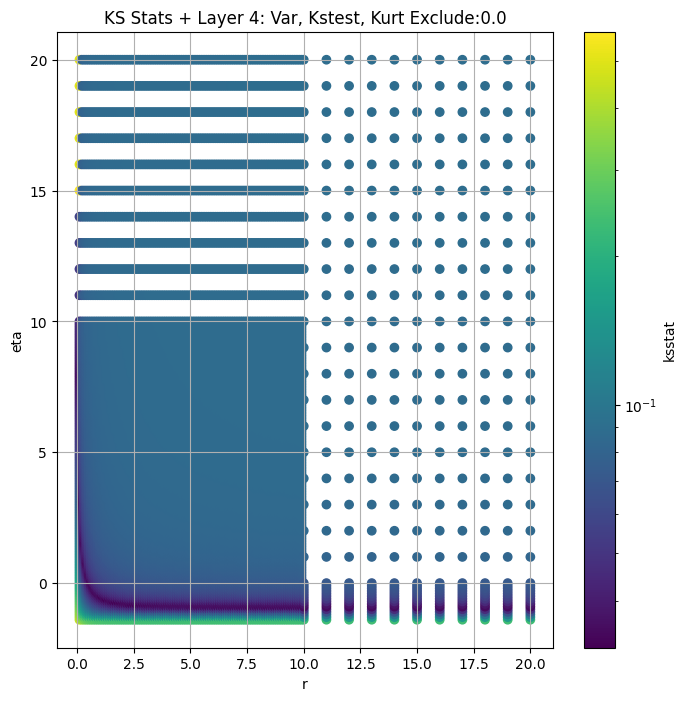

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.019364598413923684 296.3346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.061159804252769547 137.85872


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.10187042774325791 83.41165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.13373147508017386 51.156162


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.16735159973285607 31.517448


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.24422156912936183 11.240232


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.3166830326438212 3.1835134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.410082654228744 0.45578504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 nan nan


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 nan nan
Number of samples: 576, Without approximation : 576.0


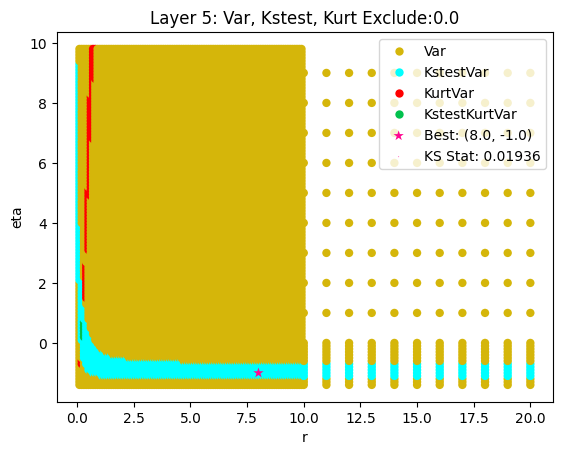

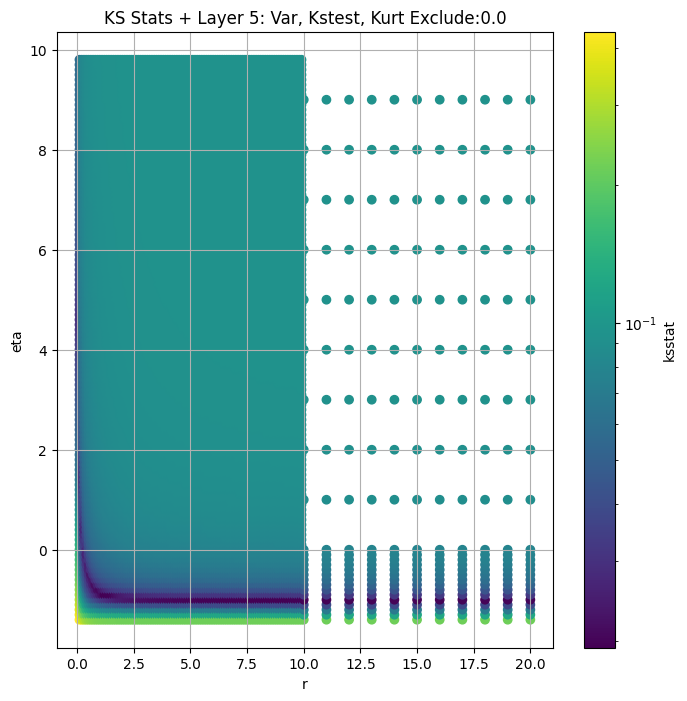

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.012874943021827456 58.38707


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.022670559818696617 41.7312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.03395806839129077 32.49966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.04221432937894741 26.13225


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.051809459050932954 21.522749


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.07372991609121124 15.104354


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.09253608168756053 11.022488


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.11128084160152996 8.254154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.1303147609581824 6.2744727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.15013135247362175 4.7846518


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.20579729386782358 2.039555
Number of samples: 2304, Without approximation : 2304.0


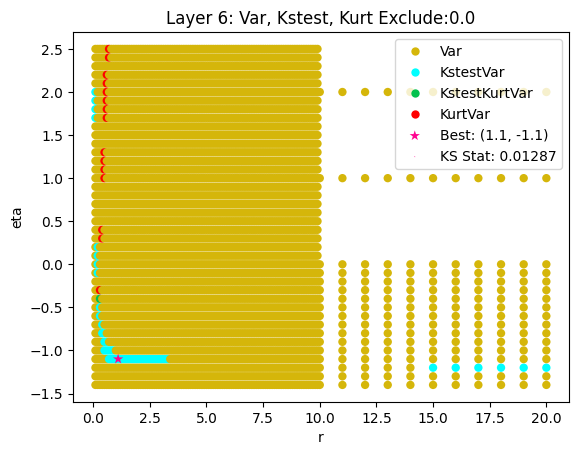

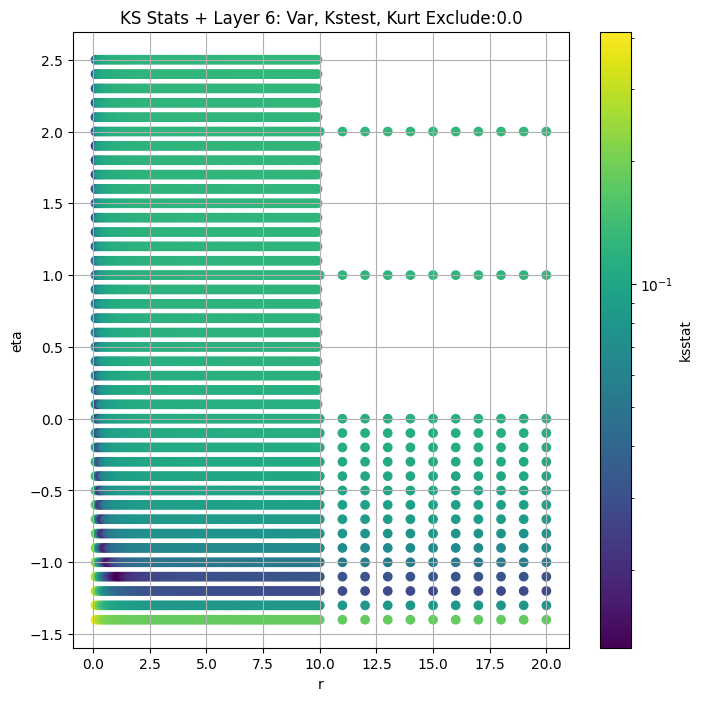

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.016259596162064793 10.897633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.016433750602941444 9.379966


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.016580179298039677 8.417982


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.018208952093853925 7.6360087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.02066642392532292 6.9934983


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.025606748301570836 5.9797626


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.031077727322040838 5.2280564


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.03571674231350963 4.637155


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.04097930456041332 4.1522665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.046542572732443555 3.7412767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.06363345650728502 2.7745109
Number of samples: 9216, Without approximation : 9216.0


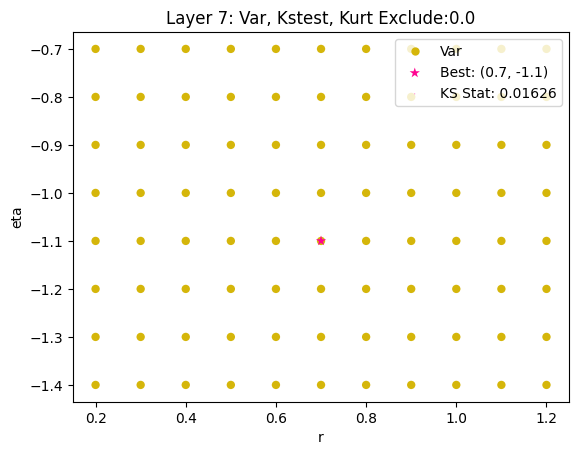

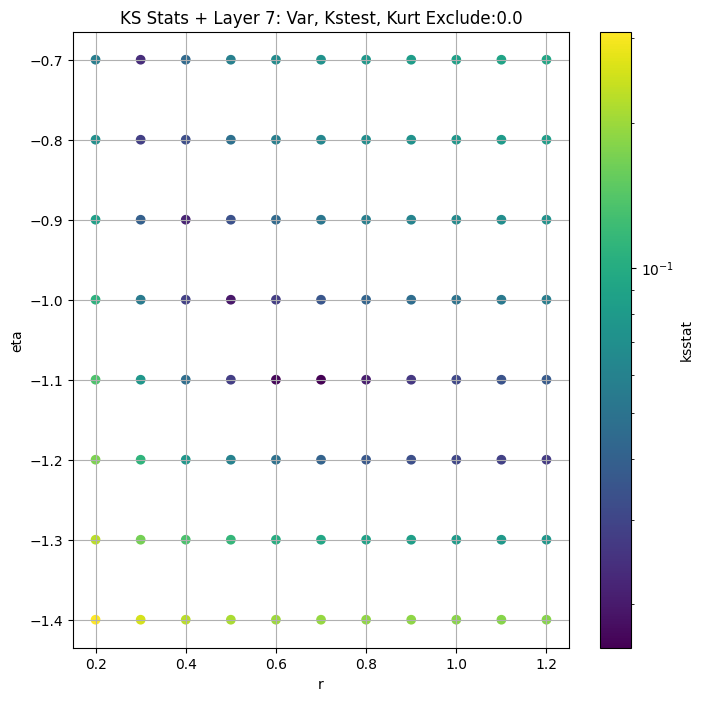

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.011847108539376094 2.0934541


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.010036115190010075 1.9850672


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.0080114528900751 1.9052125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.009904445424863906 1.8366135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.011676536422478678 1.7740656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.010597832933288753 1.6616844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.013746499377737309 1.565422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.013669772530303333 1.4811944


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.014542737591610955 1.405993


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.014420977480714803 1.3374792


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.01795656052002199 1.168221
Number of samples: 36864, Without approximation : 36864.0


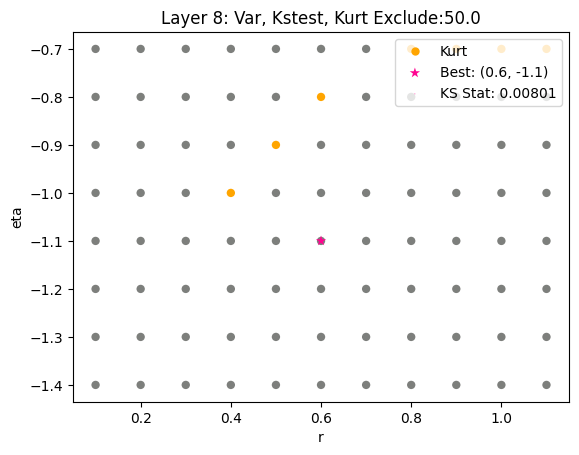

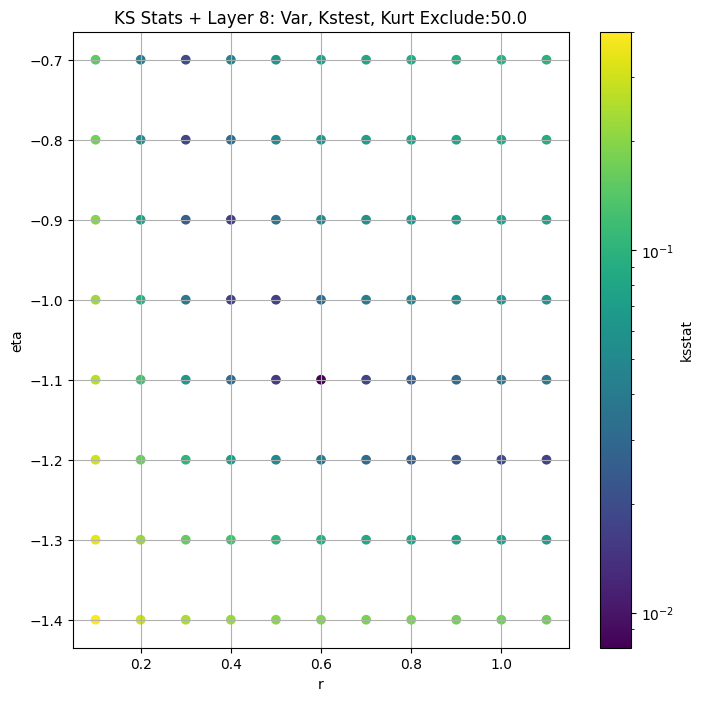

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.011979683118281875 0.37553218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.010003440820912701 0.3636352


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.009745136708414148 0.35512474


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.010664770769971632 0.34791037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.011491415653674952 0.34150904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.012993585583725209 0.3301552


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.01439964493687329 0.32012406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.012724544301499607 0.31104213


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.01225907224457512 0.3026811


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01291615936288304 0.29497662


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.014993412377509063 0.27490702
Number of samples: 100000, Without approximation : 147456.0


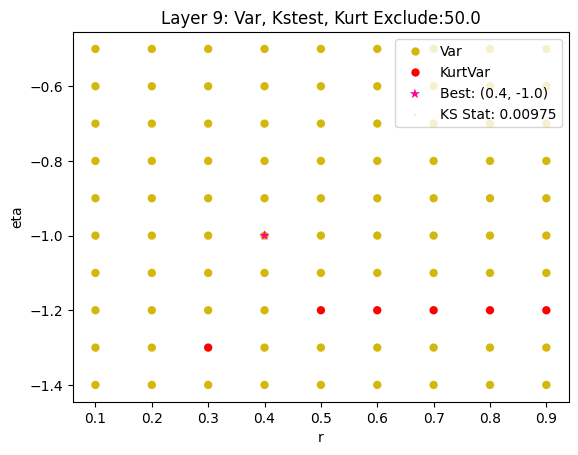

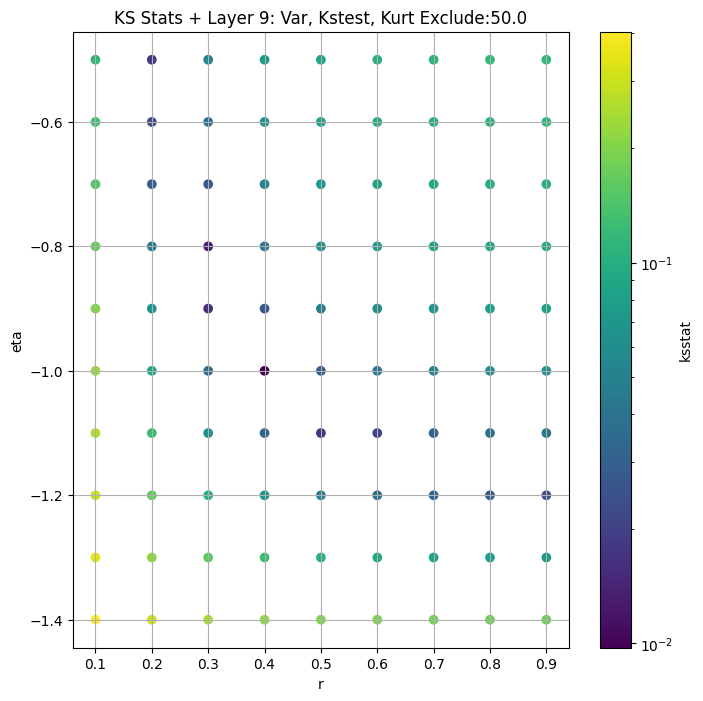

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.024429507439976073 0.059141867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.025112401000132456 0.056844447


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.0253085227748992 0.055335082


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.024918054787498534 0.05409857


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.024469933413598988 0.05301597


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.023743111653569904 0.05113007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.023508621151108855 0.049515497


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.024797302292917767 0.048072383


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.024323827138552856 0.046752263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.023828609775008225 0.045526136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.024367460890349135 0.04229507
Number of samples: 100000, Without approximation : 589824.0


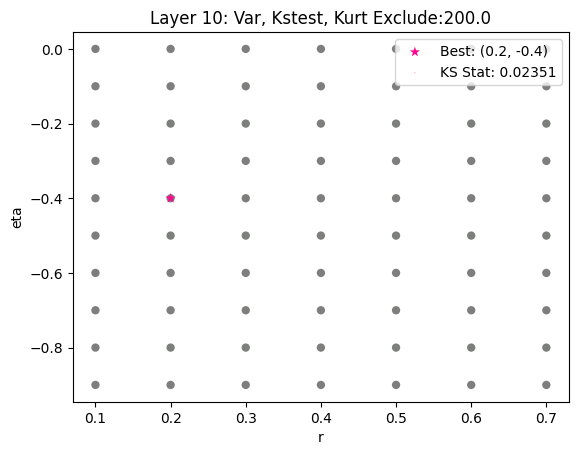

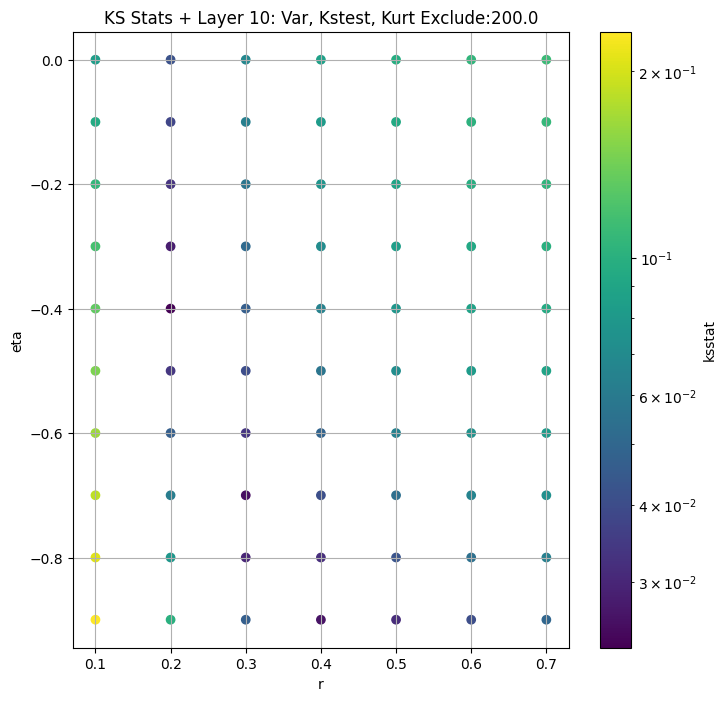

obs_var    var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                   
2      12133.633000  1262.640100  24858.705000  -0.200231   -1.861119   
3       4988.553000  2210.085700   9074.969000   0.829951   -1.383874   
4       1117.262500   710.023300   1577.433700   1.373115    0.269231   
5        296.334600   229.935680    370.397920   2.907261    1.430172   
6         58.387070    50.698250     66.482250   4.324181    3.389756   
7         10.897633    10.028848     11.798168   7.070075    5.927161   
8          2.093454     1.924215      2.268933   8.196066    7.150843   
9          0.375532     0.342325      0.410297  10.374654    8.507622   
10         0.059142     0.053647      0.065072  12.091230    9.378087   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.882851            9.0             0.293653       20.0         18.0   
3        2.973324           36.0             0.144437       20.0         20.0   
4        2.707083          144.0             0.032073        1.7         -0.7   
5        4.404983          576.0             0.019365        8.0         -1.0   
6        5.462243         2304.0             0.012875        1.1         -1.1   
7        8.451274         9216.0             0.016260        0.7         -1.1   
8        9.390152        36864.0             0.008011        0.6         -1.1   
9       12.769254       147456.0             0.009745        0.4         -1.0   
10      15.769087       589824.0             0.023509        0.2         -0.4   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       12489.077680                     0.0        12133.633000   
3        5095.426522                     0.0         4988.553000   
4        2169.272983                     0.0         1117.262500   
5         933.374006                     0.0          296.334600   
6         158.401853                     0.0           58.387070   
7          16.984843                     0.0           10.897633   
8           2.166804                    50.0            1.905212   
9           0.072776                    50.0            0.355125   
10          0.000002                   200.0            0.049515   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.430011  
3                     0.221191  
4                     0.111951  
5                     0.056290  
6                     0.028220  
7                     0.014129  
8                     0.007069  
9                     0.003536  
10                    0.001768

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 100 = 100, ksstat: nan, var: nan


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 75 = 75, ksstat: nan, var: nan


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 50 = 50, ksstat: nan, var: nan


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 25 = 25, ksstat: nan, var: nan


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.2936526629867171, var: 12133.6328125
Number of samples: 9, Without approximation : 9.0


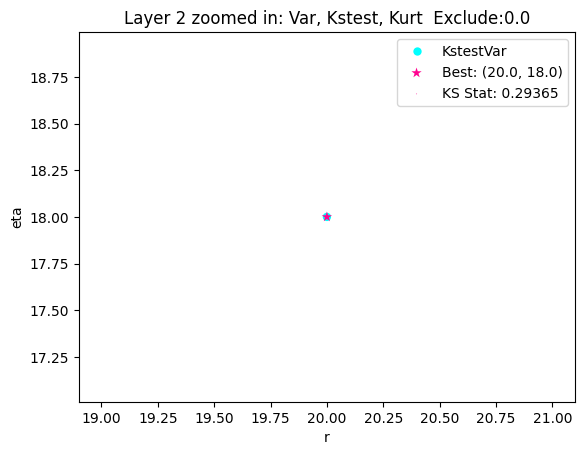

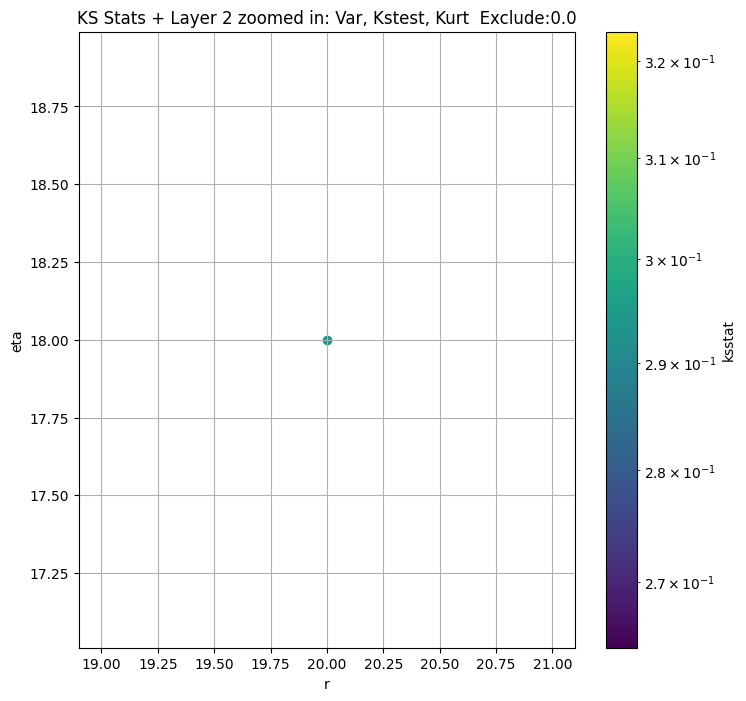

Layer 3


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 3, 0.0 + 100 = 100, ksstat: nan, var: nan


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 3, 0.0 + 75 = 75, ksstat: nan, var: nan


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 3, 0.0 + 50 = 50, ksstat: nan, var: nan


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 3, 0.0 + 25 = 25, ksstat: nan, var: nan


  0%|          | 0/1 [00:00<?, ?it/s]

Finding Minimum after computing 1 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.14443709421730433, var: 4988.55322265625
Number of samples: 36, Without approximation : 36.0


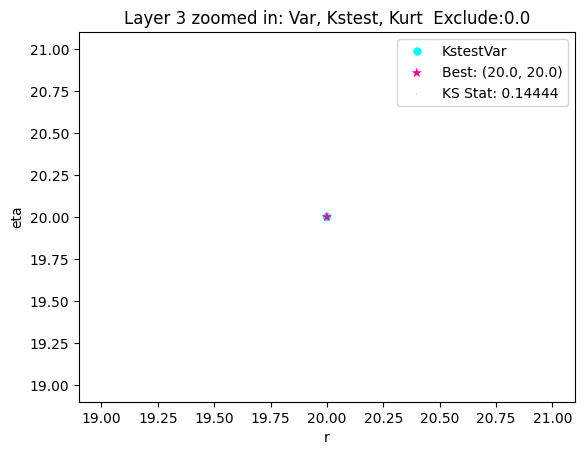

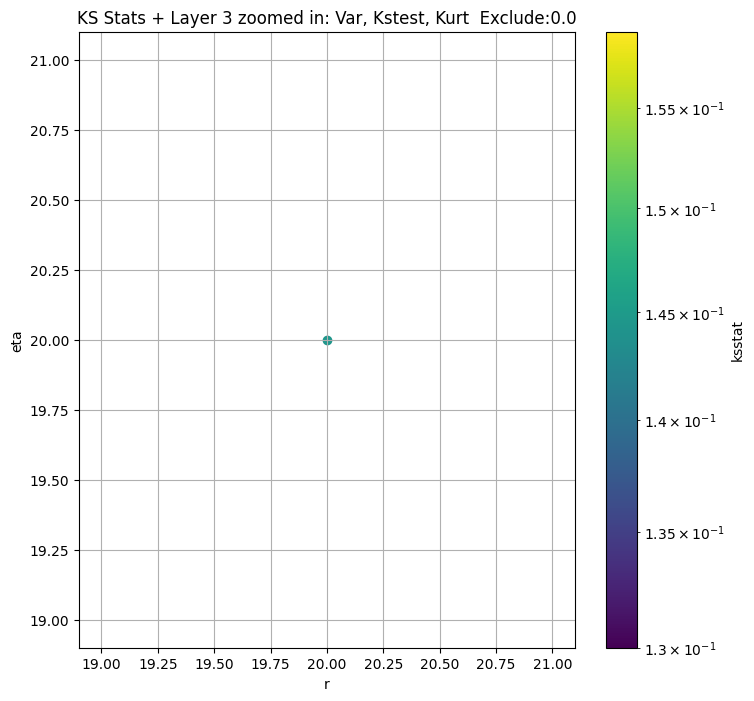

Layer 4


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 4, 0.0 + 100 = 100, ksstat: nan, var: nan


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 4, 0.0 + 75 = 75, ksstat: nan, var: nan


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.3179151396721539, var: 25.09430503845215


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.18573257116985287, var: 180.56619262695312


  0%|          | 0/1530 [00:00<?, ?it/s]

Finding Minimum after computing 1530 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.031804256285367094, var: 1117.262451171875
Number of samples: 144, Without approximation : 144.0


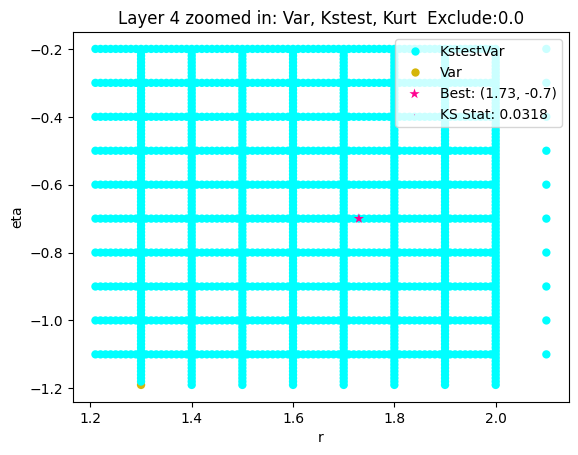

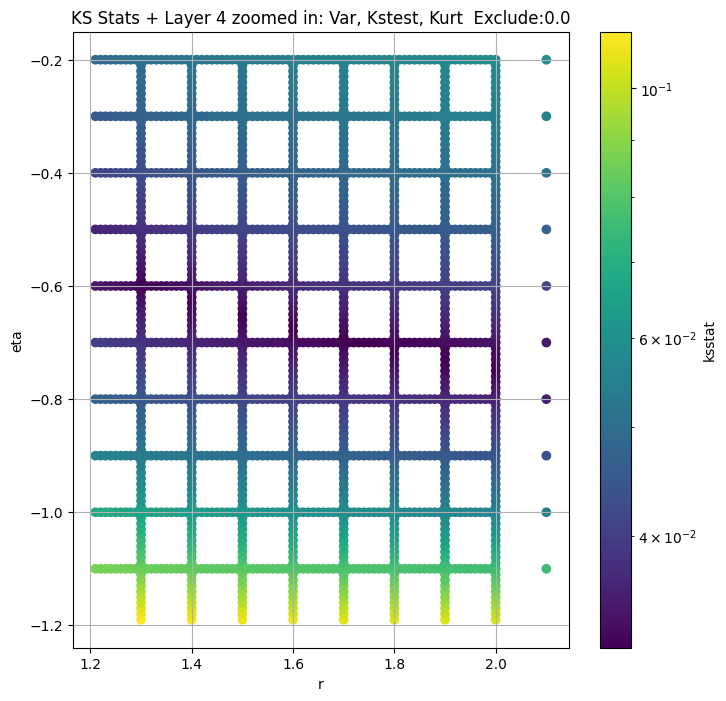

Layer 5


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.16896243752758489, var: 31.51744842529297


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.1338418485401908, var: 51.15616226196289


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.10236933944834183, var: 83.41165161132812


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.06137111749297432, var: 137.8587188720703


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.019364598413923684, var: 296.3345947265625
Number of samples: 576, Without approximation : 576.0


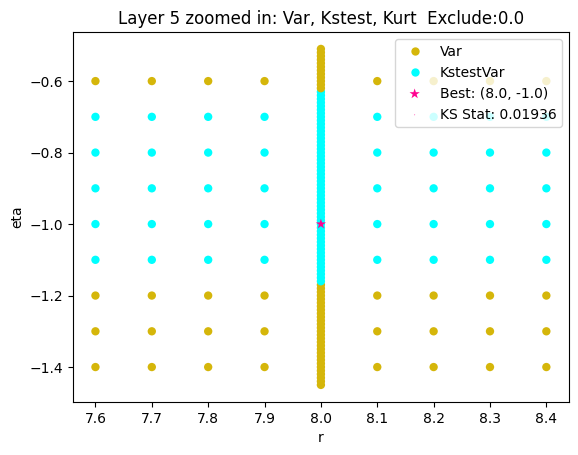

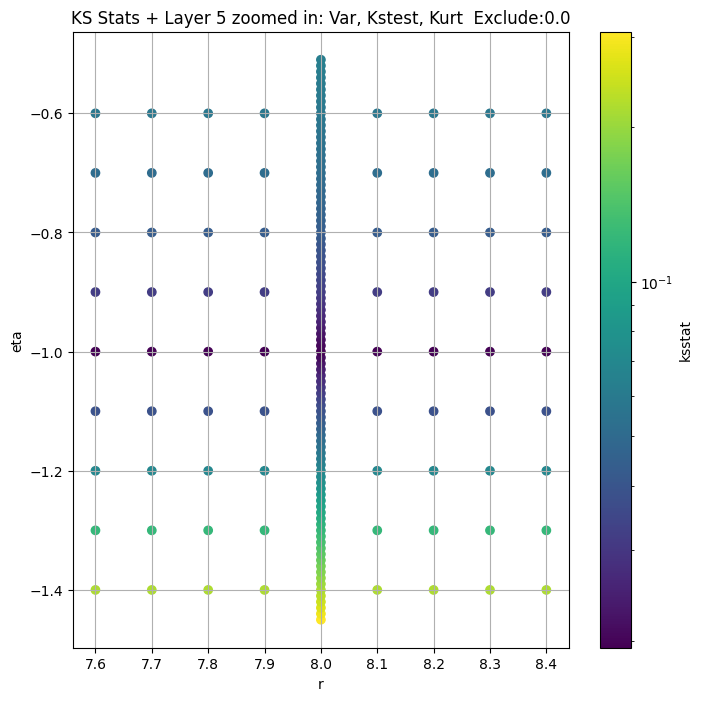

Layer 6


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.05447147941351816, var: 21.522748947143555


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.04401303802825726, var: 26.13224983215332


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.03483738871660293, var: 32.49966049194336


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.024974166554533724, var: 41.731201171875


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.012441730469424539, var: 58.38706970214844
Number of samples: 2304, Without approximation : 2304.0


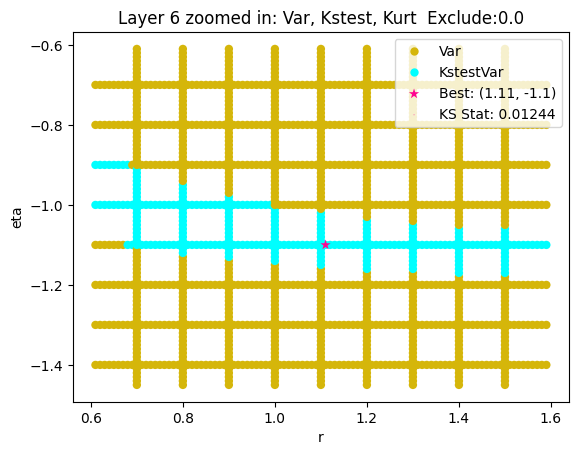

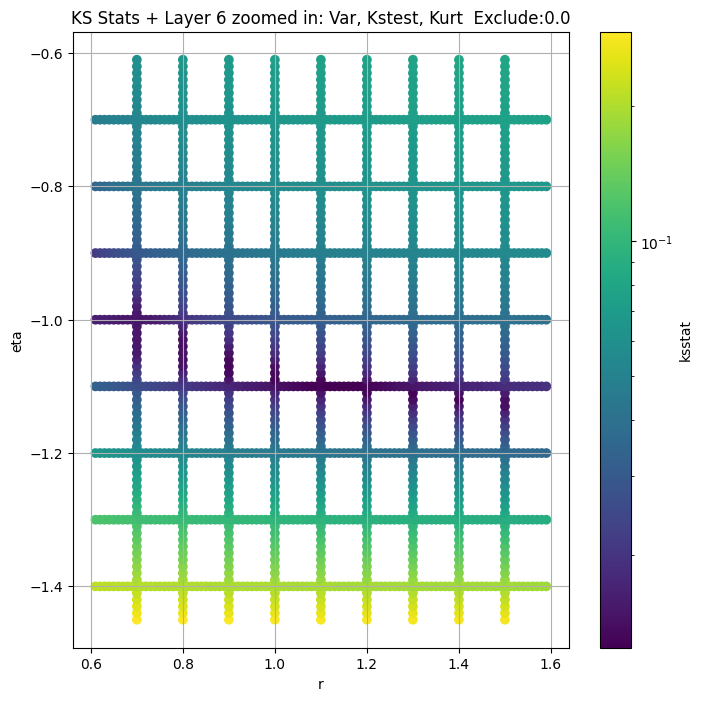

Layer 7


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.021466663068334002, var: 6.9934983253479


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.017946094950676672, var: 7.6360087394714355


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.014854574226339234, var: 8.41798210144043


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.014961033838659932, var: 9.379965782165527


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.015097110760353916, var: 10.897632598876953
Number of samples: 9216, Without approximation : 9216.0


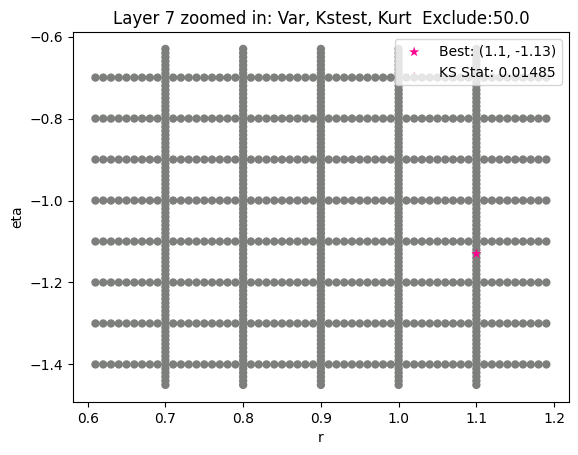

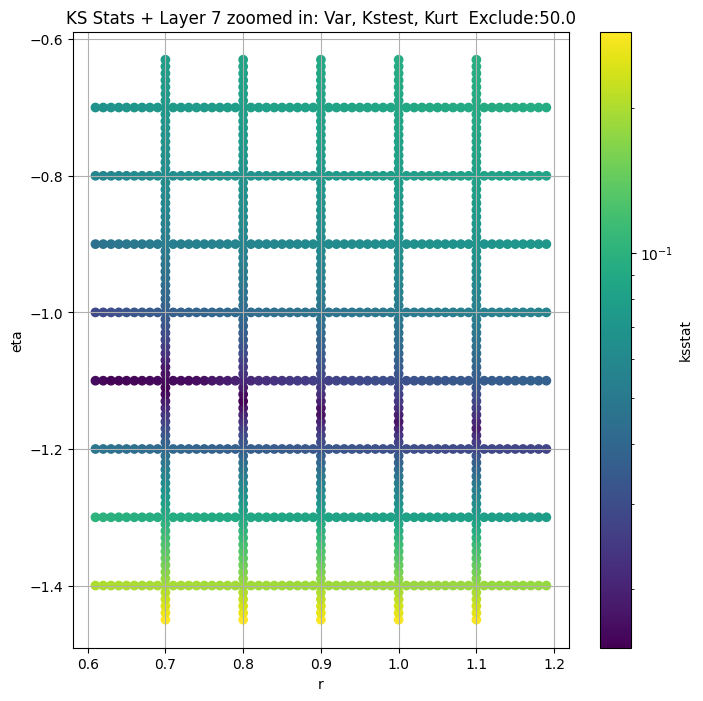

Layer 8


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 50.0 + 100 = 150, ksstat: 0.009660056068907852, var: 1.6616843938827515


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 50.0 + 75 = 125, ksstat: 0.008734954612317825, var: 1.7157213687896729


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 50.0 + 50 = 100, ksstat: 0.008520577252444927, var: 1.774065613746643


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 50.0 + 25 = 75, ksstat: 0.008670670752218834, var: 1.8366135358810425


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 50.0 + 0 = 50, ksstat: 0.0080114528900751, var: 1.9052125215530396


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 50.0 + -25 = 25, ksstat: 0.007598449609741986, var: 1.9850672483444214


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 8, 50.0 + -50 = 0, ksstat: 0.007482528908433039, var: 2.093454122543335
Number of samples: 36864, Without approximation : 36864.0


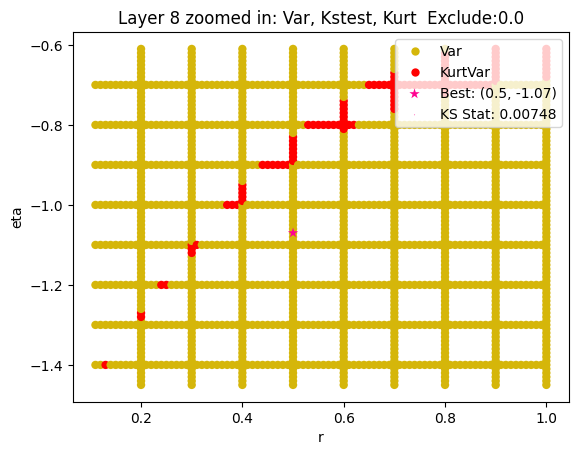

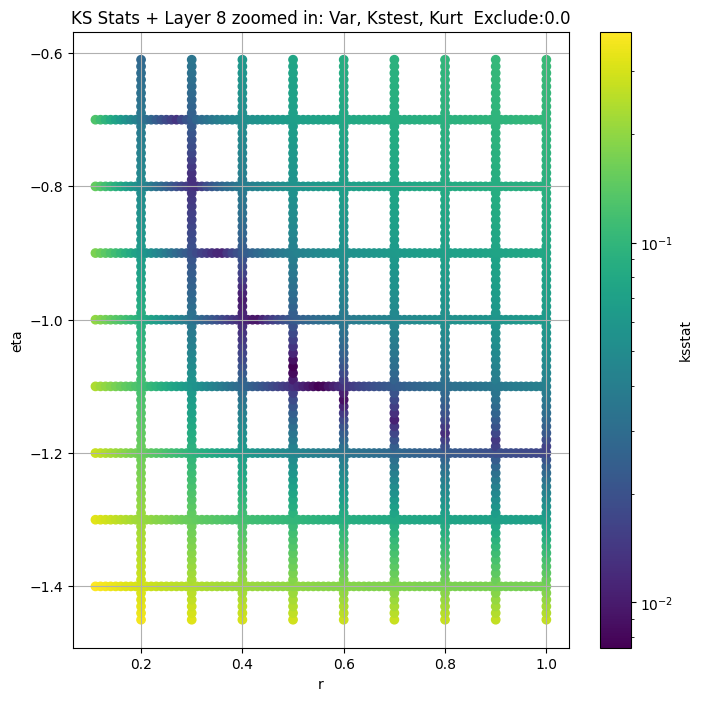

Layer 9


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 50.0 + 100 = 150, ksstat: 0.010757138704727387, var: 0.3301551938056946


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 50.0 + 75 = 125, ksstat: 0.010680202441696096, var: 0.33563053607940674


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 50.0 + 50 = 100, ksstat: 0.010549487591434592, var: 0.34150904417037964


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 50.0 + 25 = 75, ksstat: 0.009840653016522927, var: 0.3479103744029999


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 50.0 + 0 = 50, ksstat: 0.009745136708414148, var: 0.35512474179267883


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 50.0 + -25 = 25, ksstat: 0.009573497231211592, var: 0.36363521218299866


  0%|          | 0/1480 [00:00<?, ?it/s]

Finding Minimum after computing 1480 CDFs
layer 9, 50.0 + -50 = 0, ksstat: 0.009535350054962782, var: 0.3755321800708771
Number of samples: 100000, Without approximation : 147456.0


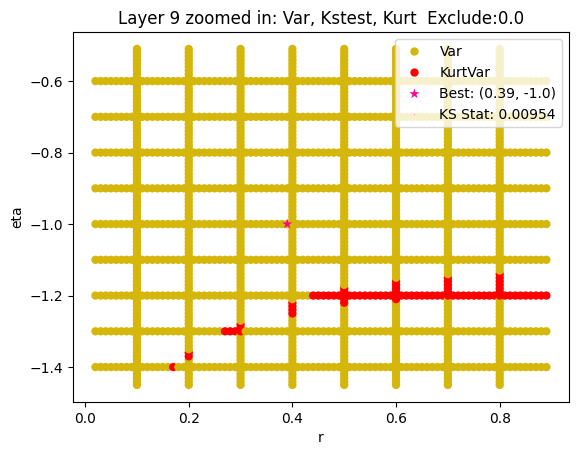

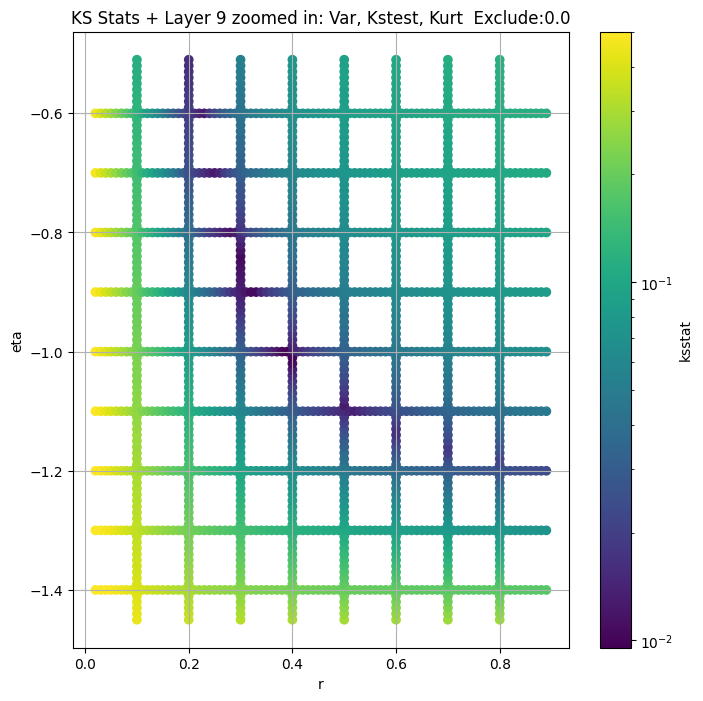

Layer 10


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + 100 = 300, ksstat: 0.02353040226570169, var: 0.046752262860536575


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + 75 = 275, ksstat: 0.02355617798553933, var: 0.047398682683706284


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + 50 = 250, ksstat: 0.023571507750074994, var: 0.04807238280773163


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + 25 = 225, ksstat: 0.0234006688631897, var: 0.04877679422497749


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + 0 = 200, ksstat: 0.023508621151108855, var: 0.0495154969394207


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + -25 = 175, ksstat: 0.023426766086399764, var: 0.050296515226364136


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + -50 = 150, ksstat: 0.023498333671503335, var: 0.05113007128238678


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + -75 = 125, ksstat: 0.023481781603180596, var: 0.05203140527009964


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
layer 10, 200.0 + -100 = 100, ksstat: 0.02346259026687203, var: 0.053015969693660736
Number of samples: 100000, Without approximation : 589824.0


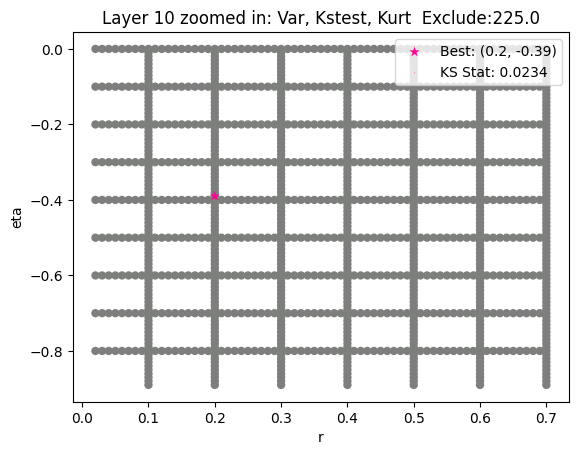

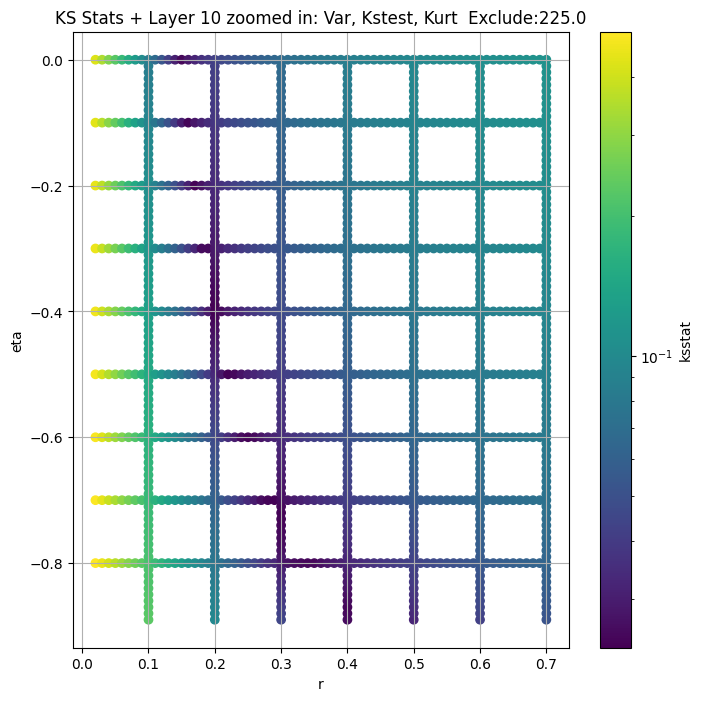

Not a fit


obs_var    var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                   
2      12133.633000  1262.640100  24858.705000  -0.200231   -1.861119   
3       4988.553000  2210.085700   9074.969000   0.829951   -1.383874   
4       1117.262500   710.023300   1577.433700   1.373115    0.269231   
5        296.334600   229.935680    370.397920   2.907261    1.430172   
6         58.387070    50.698250     66.482250   4.324181    3.389756   
7         10.897633    10.028848     11.798168   7.070075    5.927161   
8          2.093454     1.924215      2.268933   8.196066    7.150843   
9          0.375532     0.342325      0.410297  10.374654    8.507622   
10         0.059142     0.053647      0.065072  12.091230    9.378087   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.882851            9.0             0.293653       20.0         18.0   
3        2.973324           36.0             0.144437       20.0         20.0   
4        2.707083          144.0             0.032073        1.7         -0.7   
5        4.404983          576.0             0.019365        8.0         -1.0   
6        5.462243         2304.0             0.012875        1.1         -1.1   
7        8.451274         9216.0             0.016260        0.7         -1.1   
8        9.390152        36864.0             0.008011        0.6         -1.1   
9       12.769254       147456.0             0.009745        0.4         -1.0   
10      15.769087       589824.0             0.023509        0.2         -0.4   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       12489.077680                     0.0        12133.633000   
3        5095.426522                     0.0         4988.553000   
4        2169.272983                     0.0         1117.262451   
5         933.374006                     0.0          296.334600   
6         158.401853                     0.0           58.387070   
7          16.984843                     0.0            8.417982   
8           2.166804                    50.0            2.093454   
9           0.072776                    50.0            0.375532   
10          0.000002                   200.0            0.048777   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.430011          0.293653   20.00     18.00   
3                     0.221191          0.144437   20.00     20.00   
4                     0.111951          0.031804    1.73     -0.70   
5                     0.056290          0.019365    8.00     -1.00   
6                     0.028220          0.012442    1.11     -1.10   
7                     0.014129          0.014855    1.10     -1.13   
8                     0.007069          0.007483    0.50     -1.07   
9                     0.003536          0.009535    0.39     -1.00   
10                    0.001768          0.023401    0.20     -0.39   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      12489.077680                  0.0           -1  
3       5095.426522                  0.0           90  
4       2187.359845                  0.0         1843  
5        933.374006                  0.0         4920  
6        159.515202                  0.0        11664  
7         24.620303                 50.0         8748  
8          1.308736                  0.0        33214  
9          0.068134                  0.0        20736  
10         0.000002                225.0         3456

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

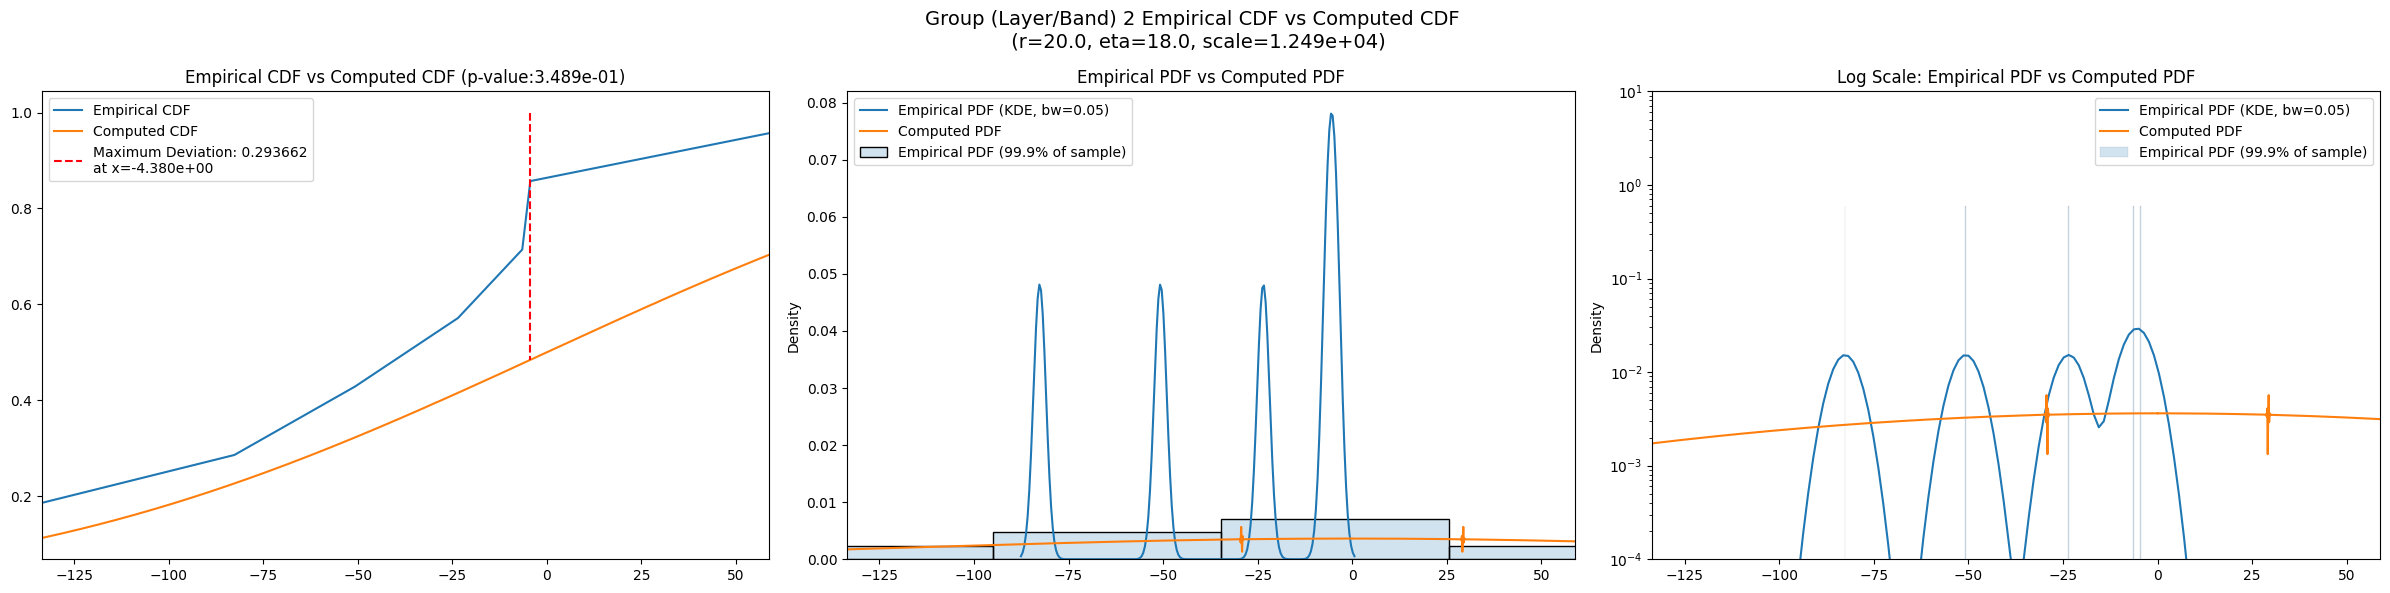

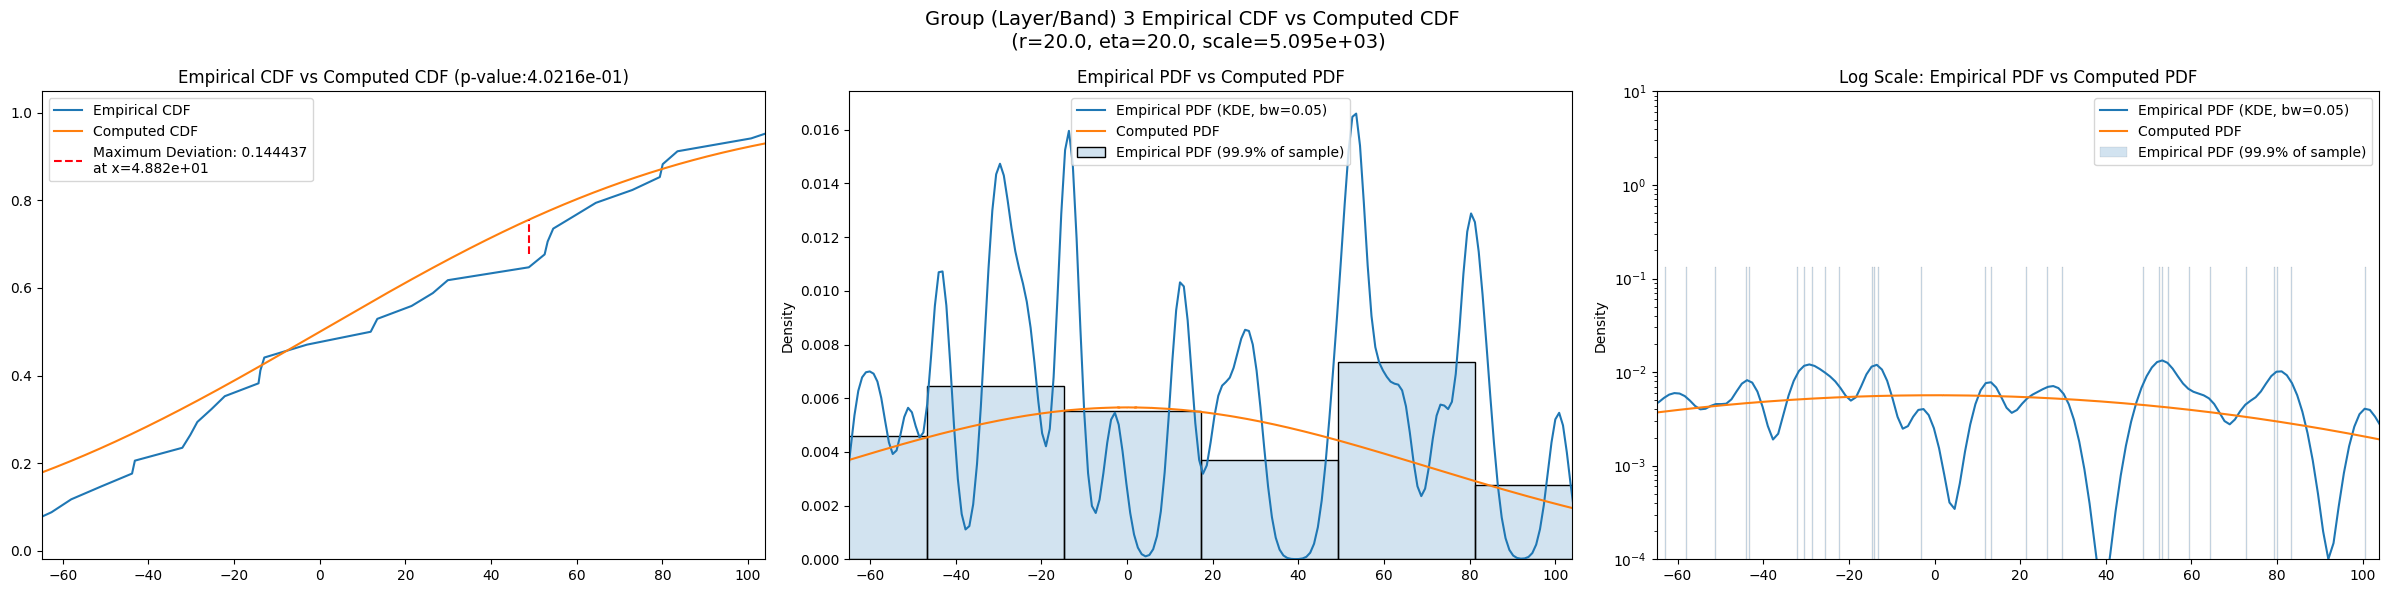

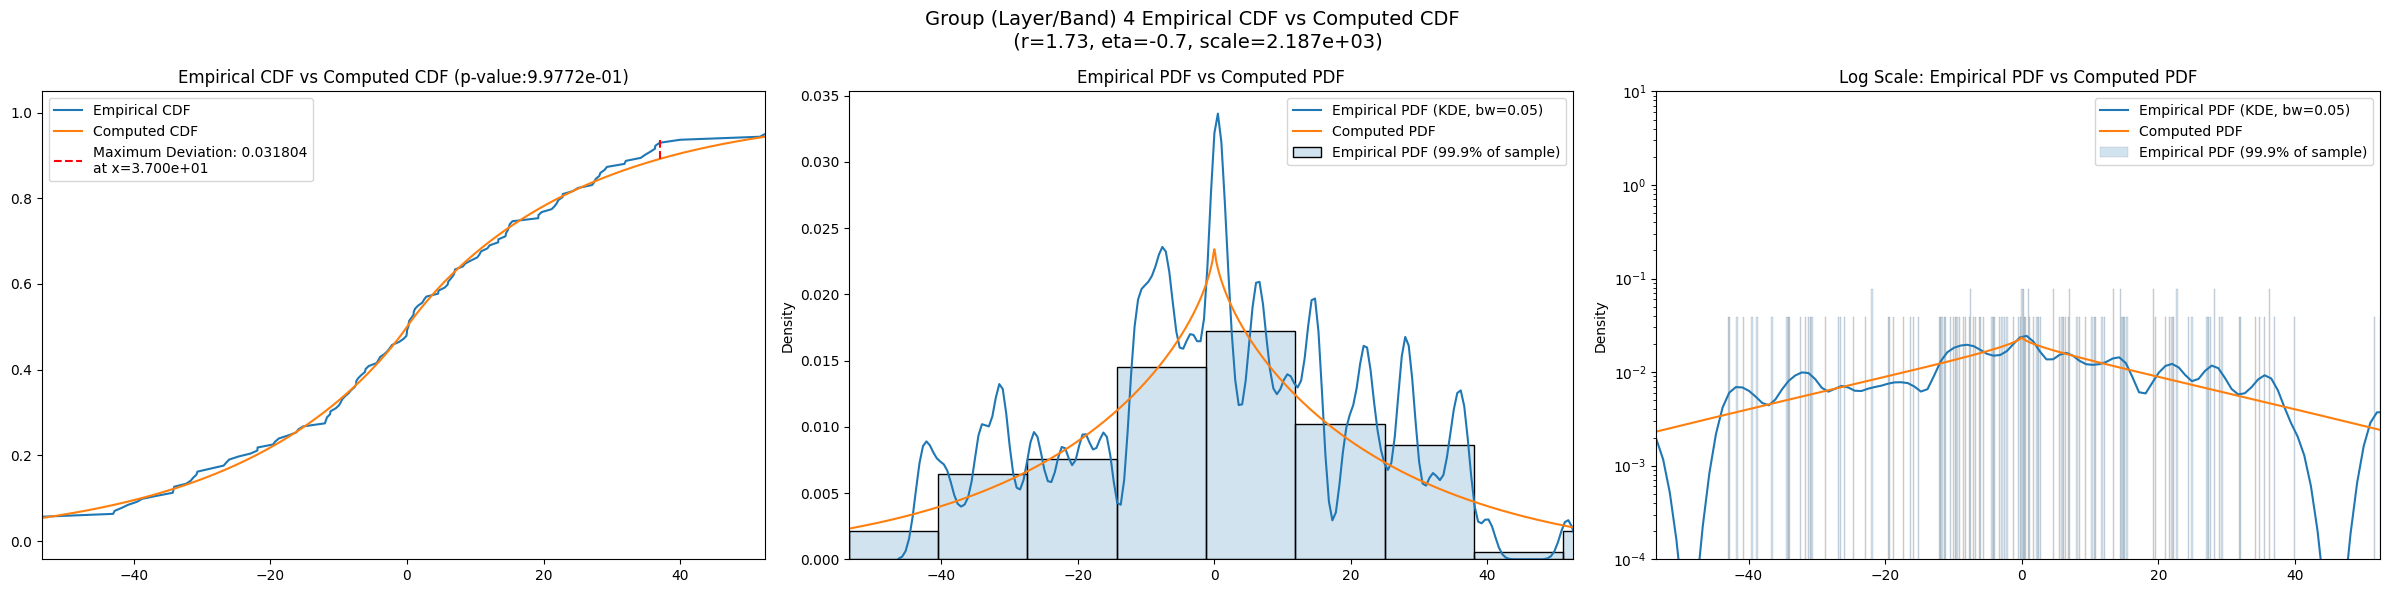

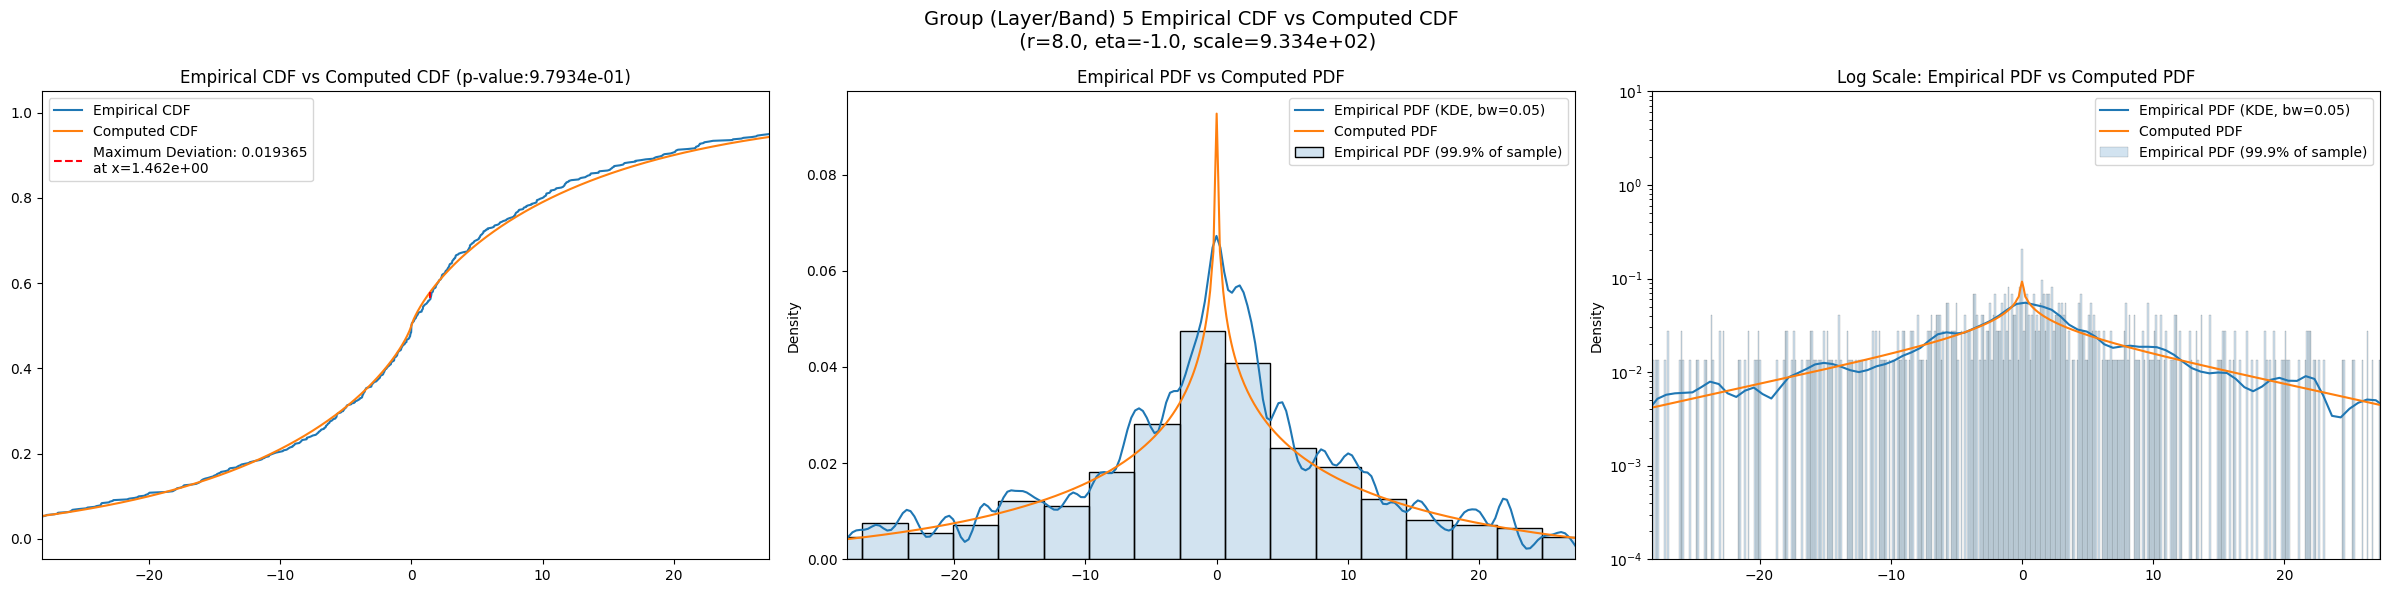

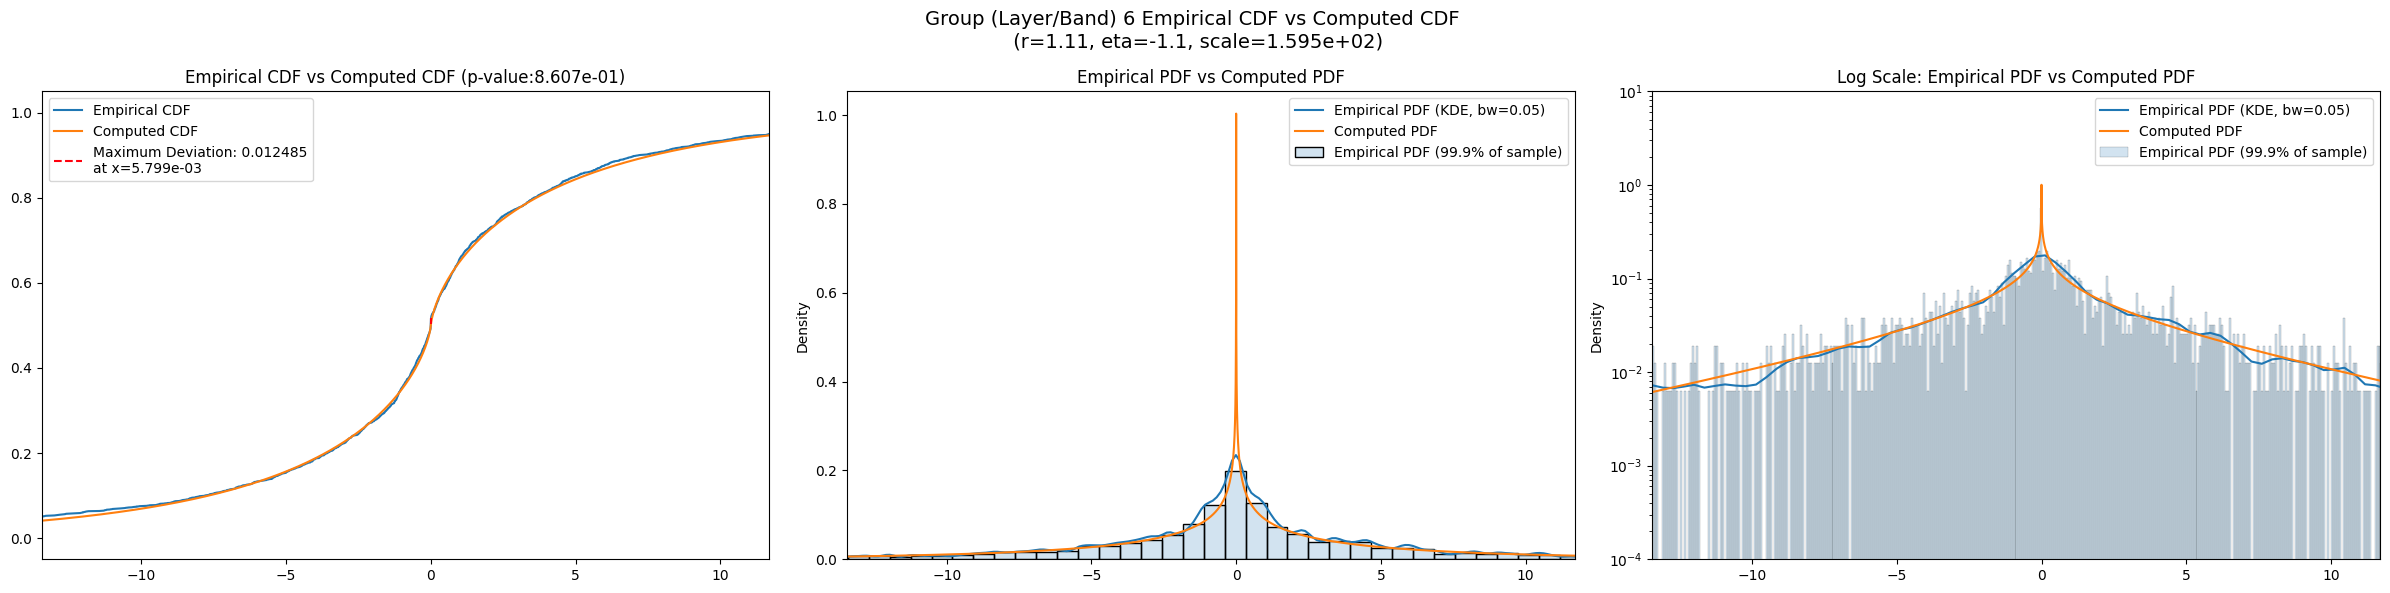

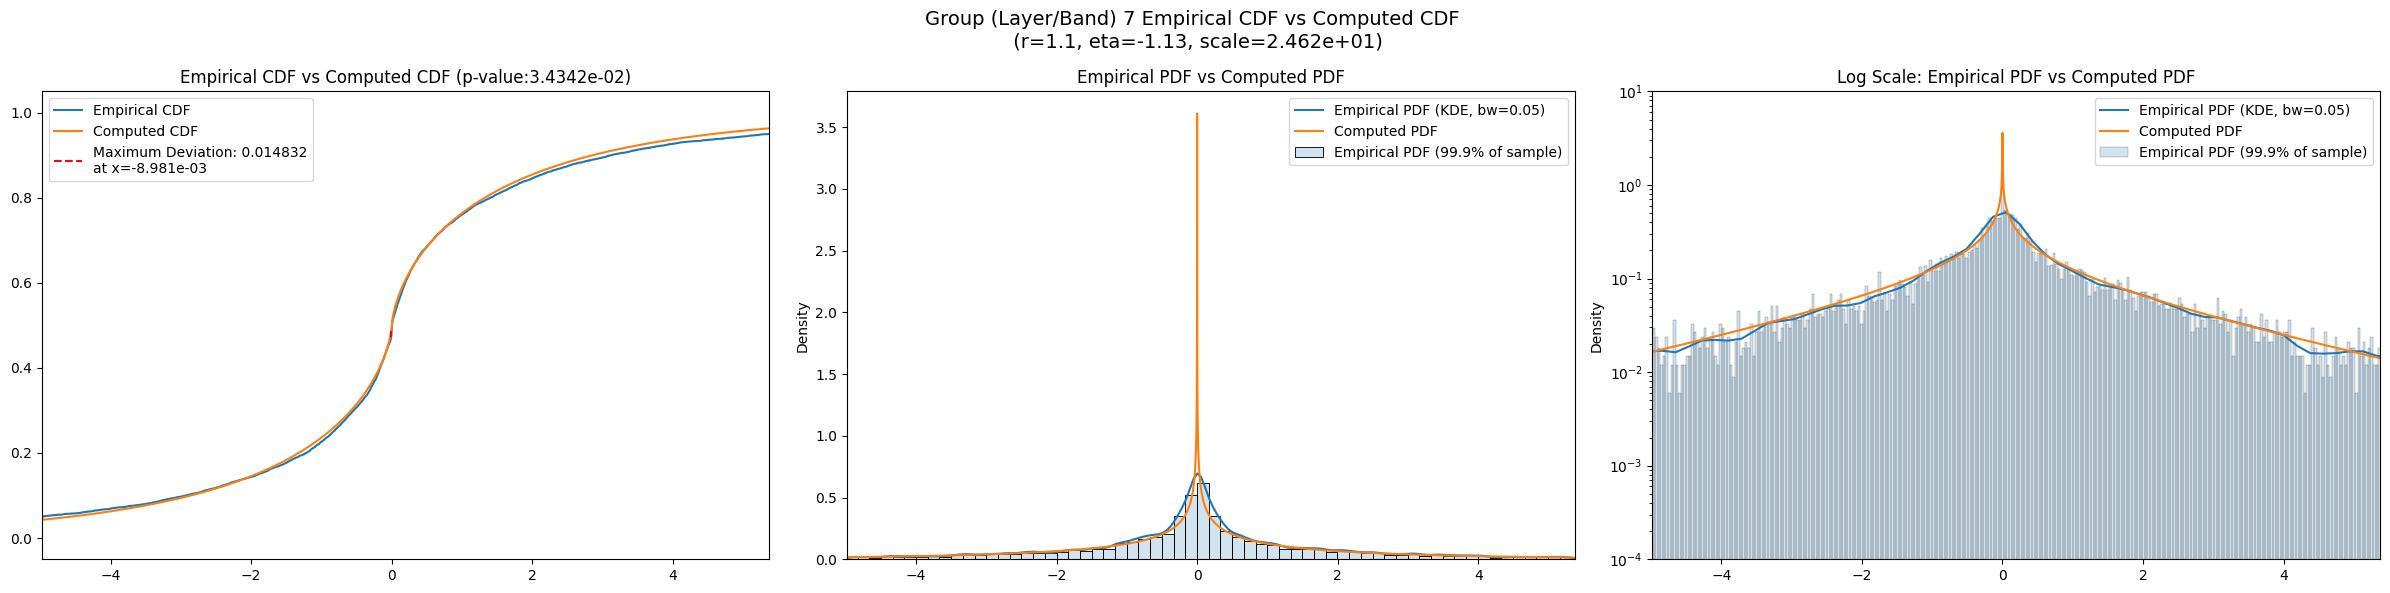

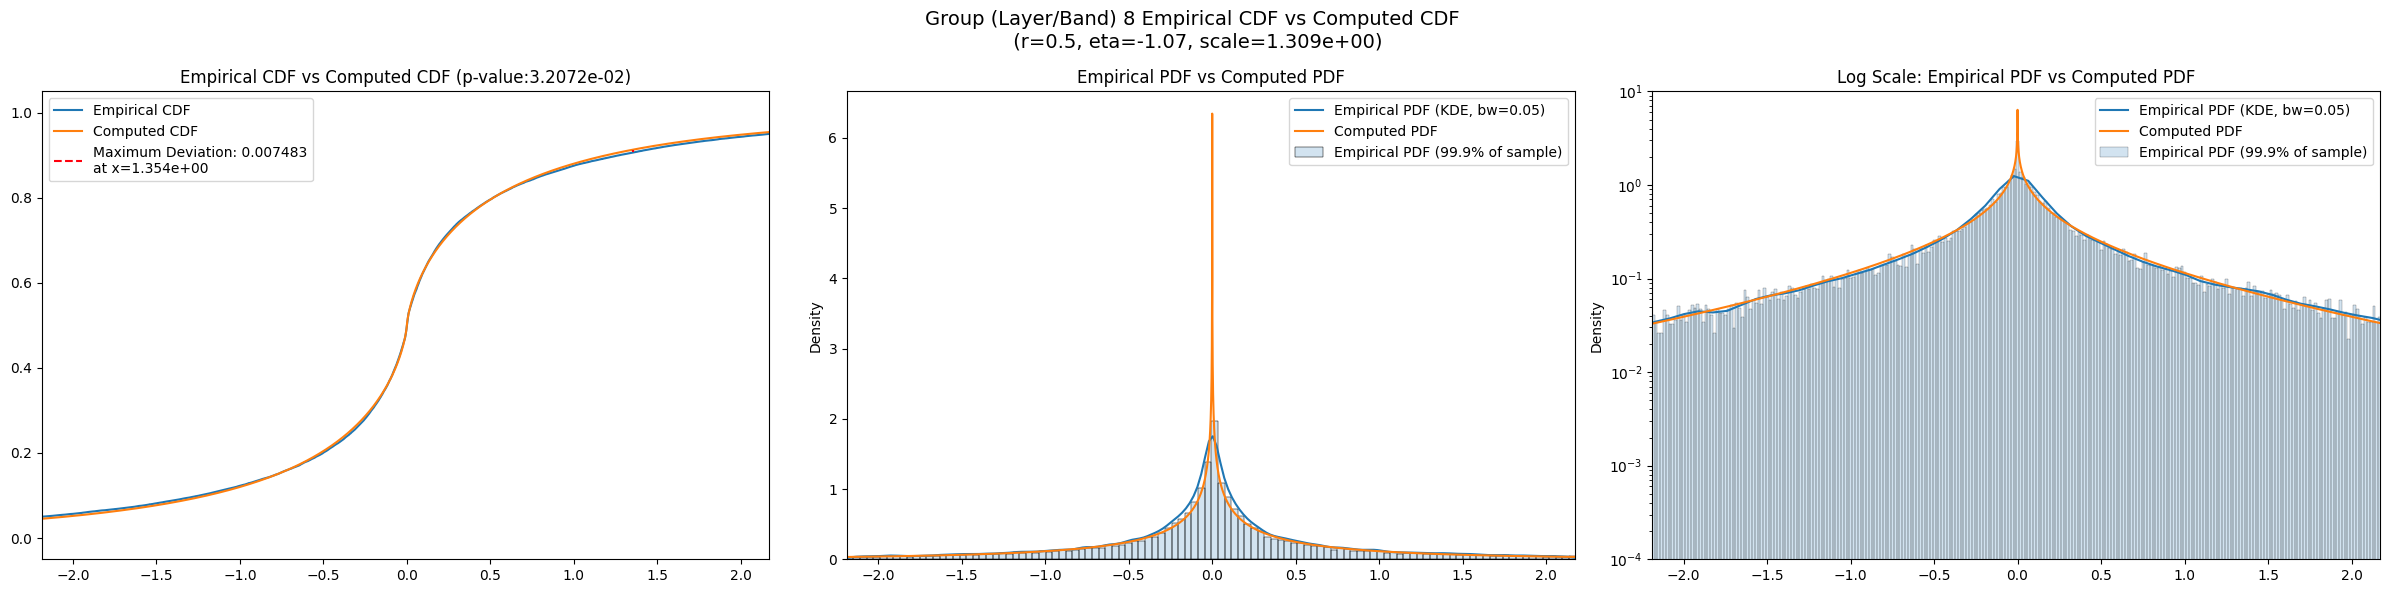

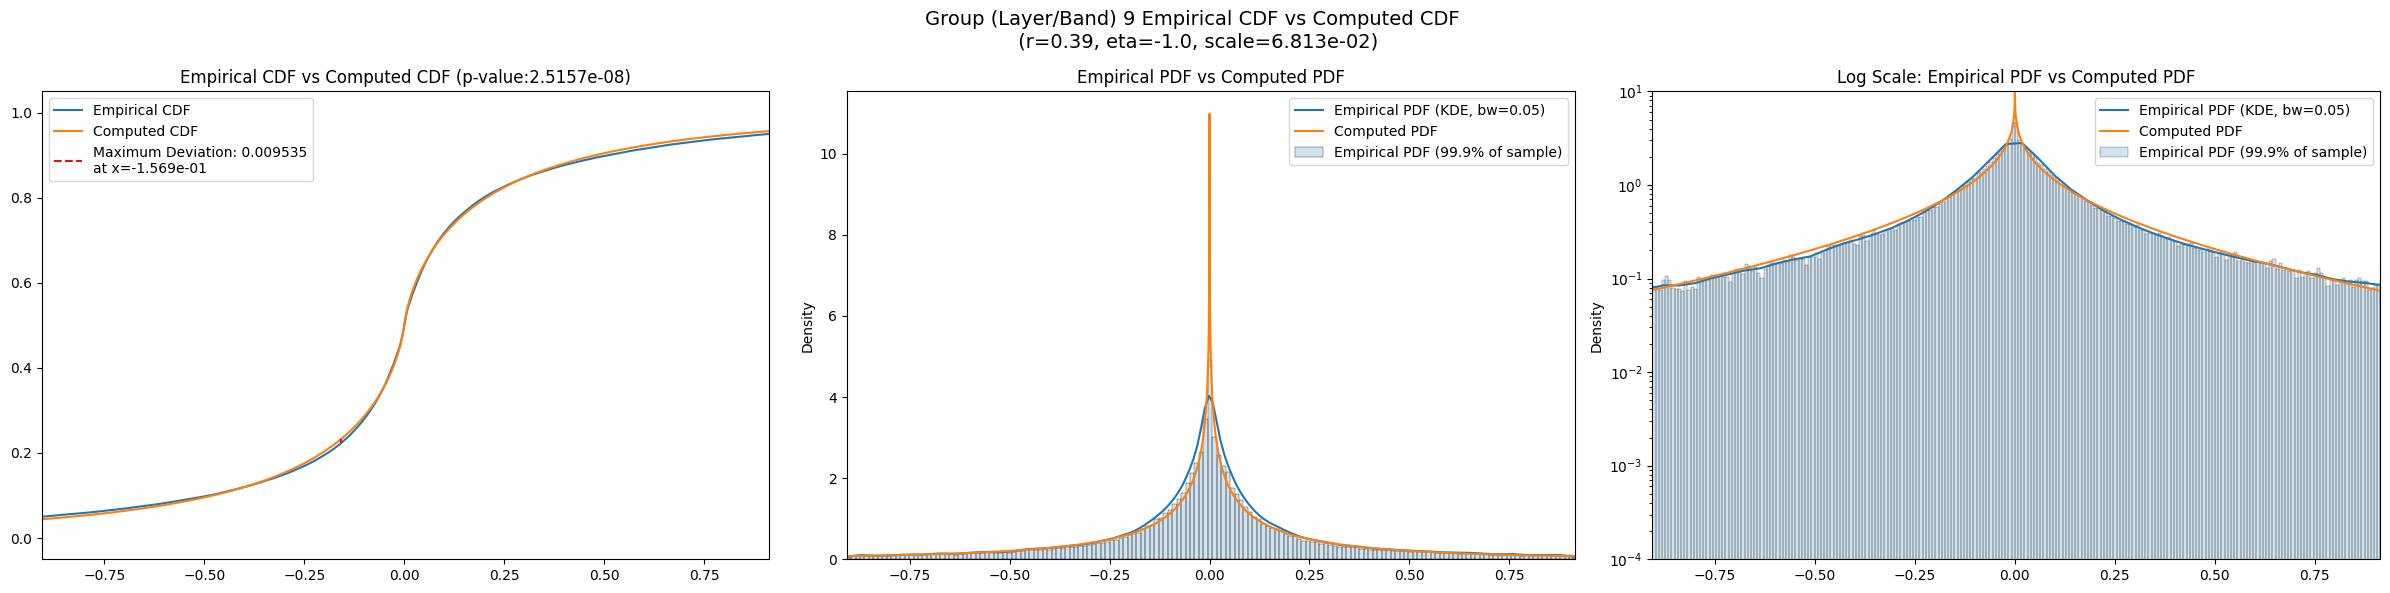

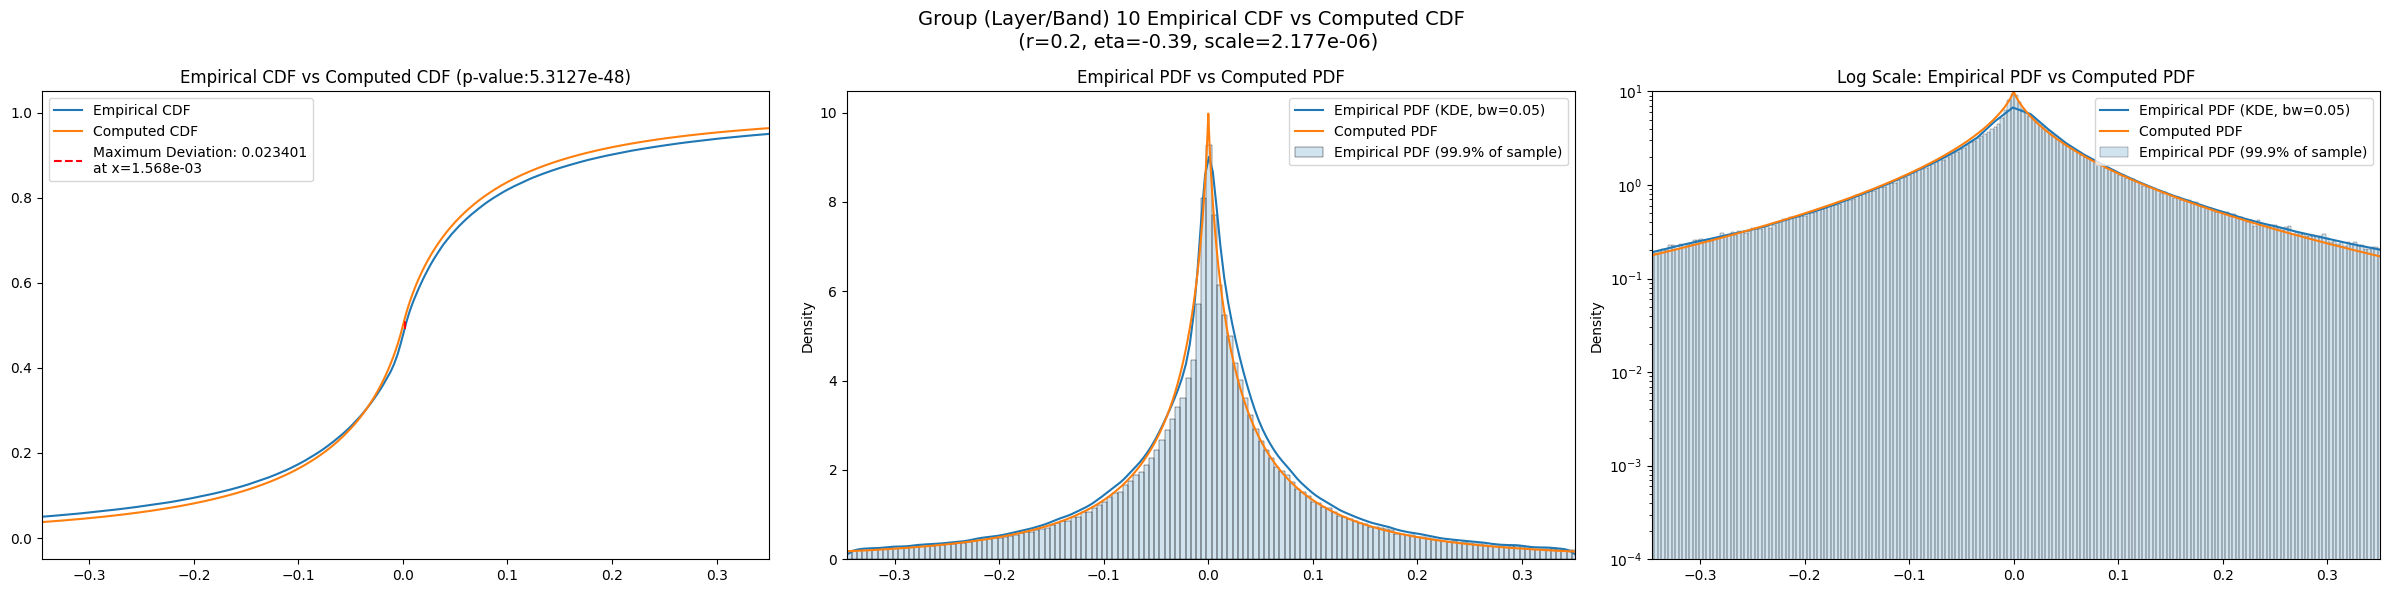

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                   
2      12133.633000  1262.640100  24858.705000  -0.200231   -1.861119   
3       4988.553000  2210.085700   9074.969000   0.829951   -1.383874   
4       1117.262500   710.023300   1577.433700   1.373115    0.269231   
5        296.334600   229.935680    370.397920   2.907261    1.430172   
6         58.387070    50.698250     66.482250   4.324181    3.389756   
7         10.897633    10.028848     11.798168   7.070075    5.927161   
8          2.093454     1.924215      2.268933   8.196066    7.150843   
9          0.375532     0.342325      0.410297  10.374654    8.507622   
10         0.059142     0.053647      0.065072  12.091230    9.378087   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        2.882851            9.0             0.293653       20.0         18.0   
3        2.973324           36.0             0.144437       20.0         20.0   
4        2.707083          144.0             0.032073        1.7         -0.7   
5        4.404983          576.0             0.019365        8.0         -1.0   
6        5.462243         2304.0             0.012875        1.1         -1.1   
7        8.451274         9216.0             0.016260        0.7         -1.1   
8        9.390152        36864.0             0.008011        0.6         -1.1   
9       12.769254       147456.0             0.009745        0.4         -1.0   
10      15.769087       589824.0             0.023509        0.2         -0.4   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      301.348000              0.283576          3.903660e-01   
3      ...       76.464100              0.127321          5.606100e-01   
4      ...       25.780200              0.049684          8.516060e-01   
5      ...       12.513800              0.057218          4.425340e-02   
6      ...        4.326060              0.067500          1.429210e-09   
7      ...        1.597990              0.076203          5.454670e-47   
8      ...        0.657135              0.074899         2.694240e-180   
9      ...        0.264640              0.074639          0.000000e+00   
10     ...        0.106351              0.070193          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         306.533000             0.284871         3.848760e-01  254.371000   
3          71.061900             0.137362         4.645370e-01   60.996100   
4          24.026700             0.032347         9.970980e-01   20.250400   
5          10.877600             0.030015         6.656700e-01    8.971580   
6           3.800370             0.041952         5.830890e-04    3.008190   
7           1.365770             0.050773         4.352290e-21    1.083370   
8           0.568358             0.048432         1.379780e-75    0.444856   
9           0.231449             0.048215        2.494620e-298    0.180609   
10          0.089592             0.047073         0.000000e+00    0.069586   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.283865   3.891360e-01          3.489322e-01  
3           0.135175   4.847860e-01          4.021625e-01  
4           0.035660   9.900650e-01          9.977172e-01  
5           0.034771   4.785460e-01          9.793420e-01  
6           0.042903   4.016860e-04          8.634479e-01  
7           0.053283   3.508420e-23          3.391025e-02  
8           0.049858   4.451950e-80          3.207197e-02  
9           0.047751  1.272940e-292          4.495403e-12  
10          0.049199   0.000000e+00       

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.293653                 0.430011          0.293653   
3                 0.144437                 0.221191          0.144437   
4                 0.032073                 0.111951          0.031804   
5                 0.019365                 0.056290          0.019365   
6                 0.012875                 0.028220          0.012442   
7                 0.016260                 0.014129          0.014855   
8                 0.008011                 0.007069          0.007483   
9                 0.009745                 0.003536          0.009535   
10                0.023509                 0.001768          0.023401   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.283576             0.284871       0.283865  
3                  0.127321             0.137362       0.135175  
4                  0.049684             0.032347       0.035660  
5                  0.057218             0.030015       0.034771  
6                  0.067500             0.041952       0.042903  
7                  0.076203             0.050773       0.053283  
8                  0.074899             0.048432       0.049858  
9                  0.074639             0.048215       0.047751  
10                 0.070193             0.047073       0.049199

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            12133.633000          0.293653   20.00     18.00  12489.077680   
3             4988.553000          0.144437   20.00     20.00   5095.426522   
4             1117.262451          0.031804    1.73     -0.70   2187.359845   
5              296.334600          0.019365    8.00     -1.00    933.374006   
6               58.387070          0.012442    1.11     -1.10    159.515202   
7                8.417982          0.014855    1.10     -1.13     24.620303   
8                2.093454          0.007483    0.50     -1.07      1.308736   
9                0.375532          0.009535    0.39     -1.00      0.068134   
10               0.048777          0.023401    0.20     -0.39      0.000002   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                     50.0  
8                      0.0  
9                      0.0  
10                   225.0

In [21]:
eng.quit()